In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-10-01 09:46:28,910 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-10-01 09:46:28,952 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Prepare evidence for maxquant

In [11]:
import glob

pattern = "120min_library_im_ref_*_*_20240928_*_*"

matching_files = glob.glob(pattern, root_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/")
matching_files = [
    os.path.join("/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/", f) for f in matching_files
]

2024-10-01 10:52:15,938 - postprocessing.protein_quant - INFO - Keep ['Protein group IDs', 'Potential contaminant', 'Proteins'] for directLFQ
2024-10-01 10:52:15,940 - postprocessing.protein_quant - INFO - Processing B_5134


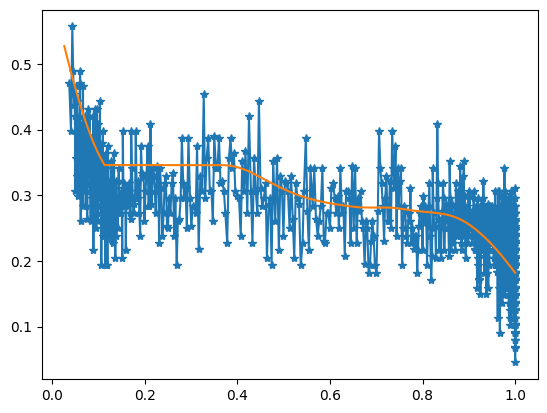

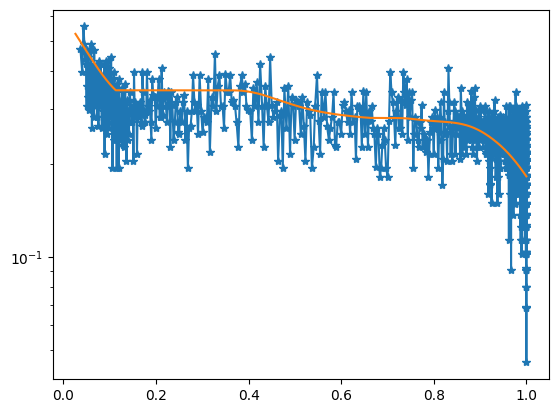

2024-10-01 10:52:25,886 - postprocessing.protein_quant - INFO - Processing A_5133


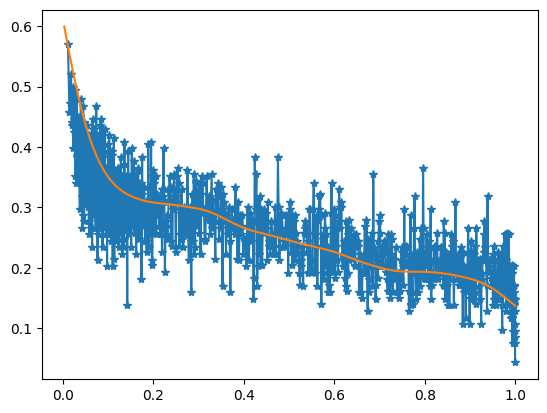

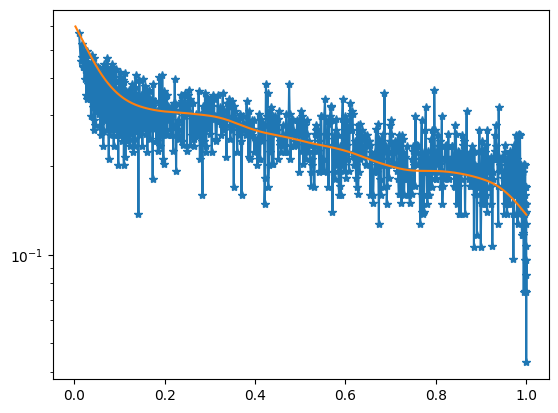

2024-10-01 10:52:35,944 - postprocessing.protein_quant - INFO - Processing A_5137


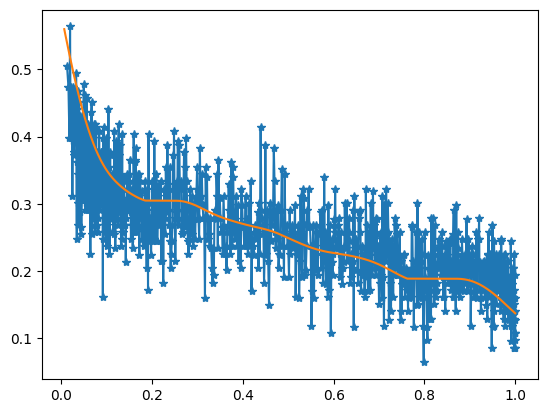

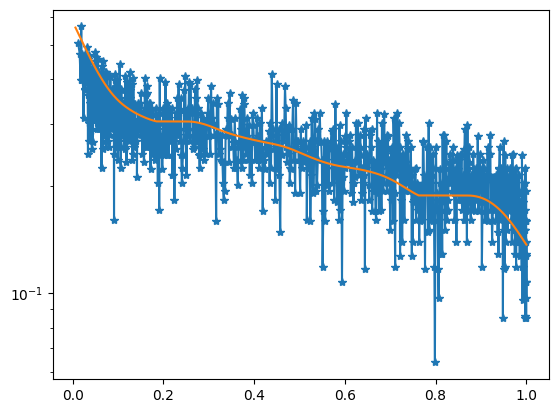

2024-10-01 10:52:46,061 - postprocessing.protein_quant - INFO - Processing B_5138


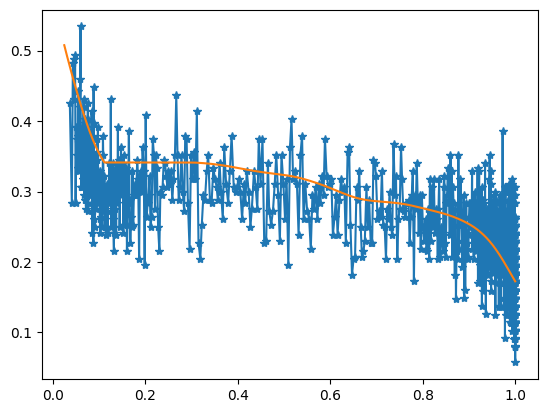

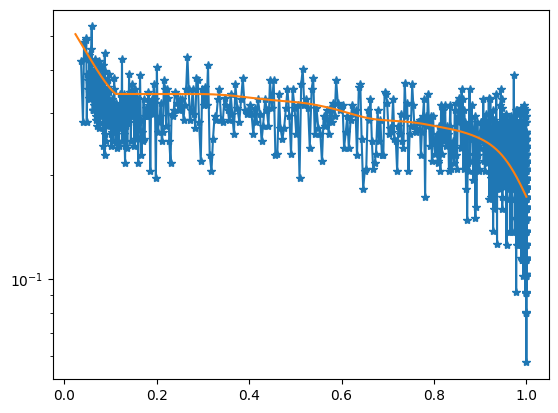

2024-10-01 10:52:56,476 - postprocessing.protein_quant - INFO - Processing B_5140


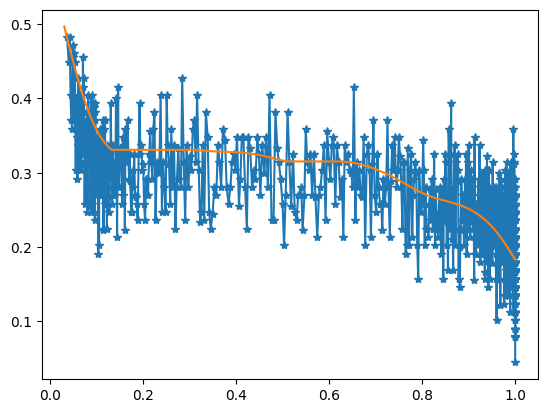

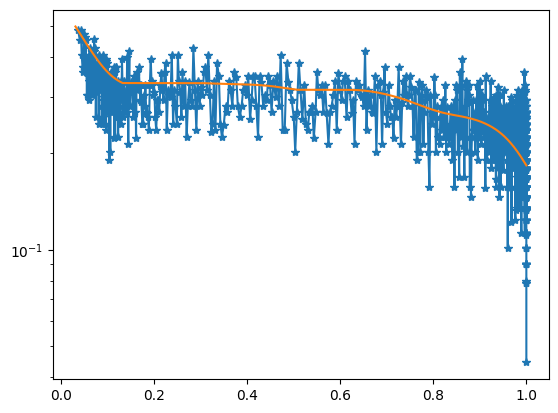

2024-10-01 10:53:06,977 - postprocessing.protein_quant - INFO - Processing A_5139


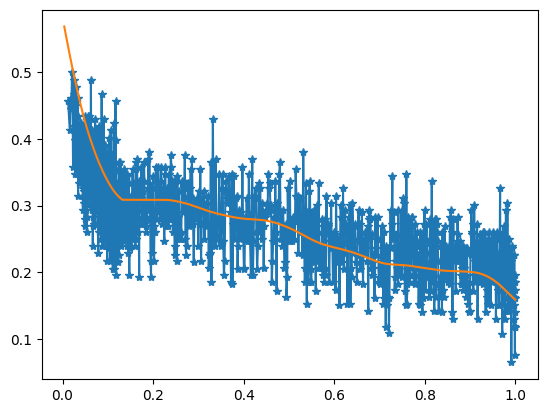

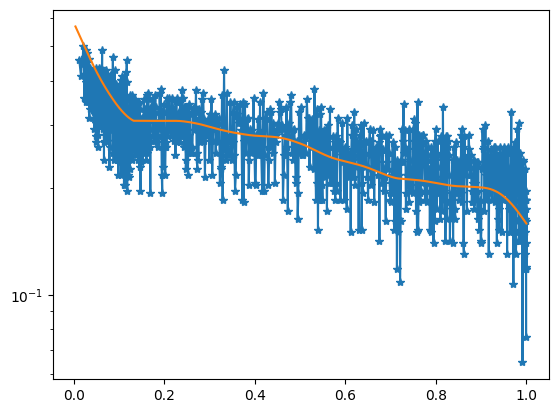

2024-10-01 10:53:16,395 - postprocessing.protein_quant - INFO - Processing A_5135


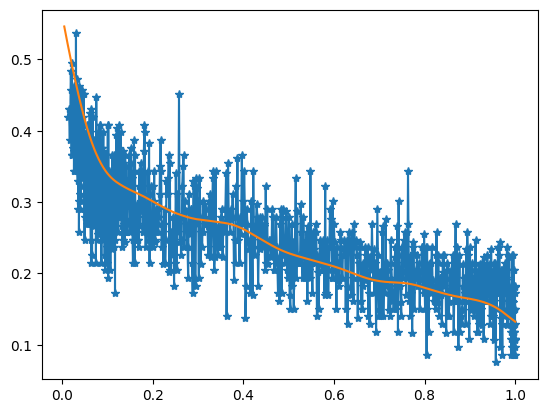

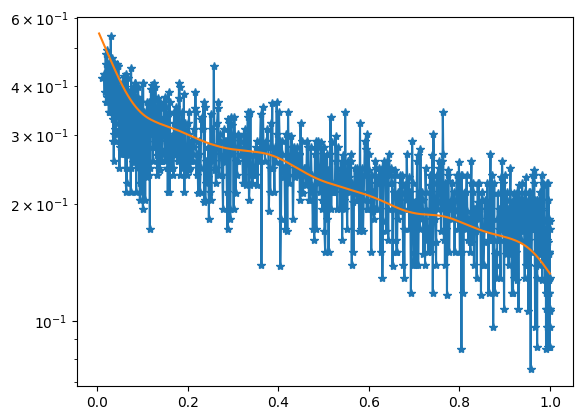

2024-10-01 10:53:27,773 - postprocessing.protein_quant - INFO - Processing B_5136


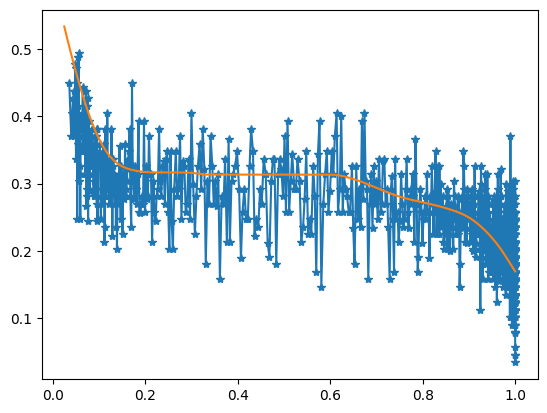

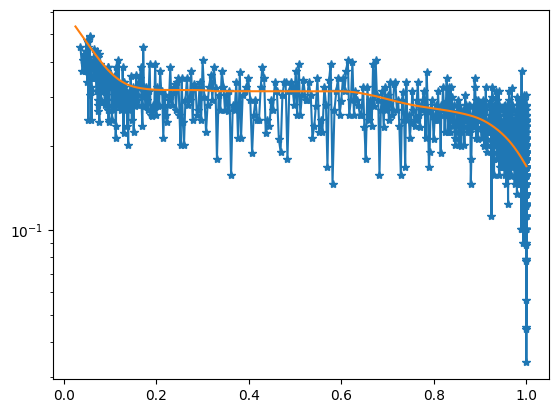

In [32]:
%autoreload 2
from postprocessing.protein_quant import prepare_evidence_for_pickedgroupfdr

out_dir, evidcen_all = prepare_evidence_for_pickedgroupfdr(
    matching_files,
    out_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/120min_library_im_ref",
)

In [18]:
evidence_swaps = pd.read_csv(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/120min_library_im_ref/evidence_swaps.txt",
    sep="\t",
)

In [19]:
protein_groups = pd.read_csv(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/120min_library_im_ref/proteinGroups.txt",
    sep="\t",
)

# Load data

In [30]:
example_maxquant_result_ref = pd.read_pickle(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/A_5139_20240912_134700_126900/maxquant_result_ref.pkl"
)

In [31]:
example_maxquant_result_ref.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
       'Time_minute_left_ref', 'MS1_frame_idx_left_ref',
       'Time_minute_right_ref', 'MS1_frame_idx_right_ref', 'IsoMZ',
       'IsoAbundance', 'mz_rank', 'mz_bin', 'mz_length', 'pept_batch_idx'],
      dtype='object', length=121)

## Protein group

In [4]:
h_protein_120min = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/tims_ramp_time/HeLa_library/txt_Hela_DDA_120min/proteinGroups.txt",
    sep="\t",
)
y_protein_120min = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/species_mix/DDA/txt_yeast_120min/proteinGroups.txt",
    sep="\t",
)
e_protein_120min = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/species_mix/DDA/txt_ecoli_120min/proteinGroups.txt",
    sep="\t",
)
mix_grouping_30min = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/species_mix/DDA/txt_HYE_5ug/proteinGroups.txt",
    sep="\t",
)
mix_grouping_120min = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/species_mix/DDA/txt_HYE_120min_sep/proteinGroups.txt",
    sep="\t",
)

/tmp/ipykernel_553044/193489170.py:13: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  mix_grouping_30min = pd.read_csv(


In [ ]:
# Create a dictionary from 'mix_grouping' for faster lookups
id_to_taxonomy = dict(
    zip(mix_grouping_30min["id"], mix_grouping_30min["Taxonomy names"])
)

In [5]:
from postprocessing.protein_quant import append_species_from_fasta_header

mix_grouping_30min["Taxonomy names"] = mix_grouping_30min["Fasta headers"].apply(
    append_species_from_fasta_header
)

In [6]:
mix_grouping_30min["Taxonomy names"].value_counts()

Taxonomy names
Homo sapiens                4955
Saccharomyces cerevisiae    2934
Escherichia coli K-12       1404
                              87
Name: count, dtype: int64

In [7]:
from postprocessing.protein_quant import populate_taxonomy_from_protein_ids

# Apply the function to the 'Protein IDs' column and populate the 'Taxonomy names' column
h_protein_120min["Taxonomy names"] = h_protein_120min["Protein IDs"].apply(
    populate_taxonomy_from_protein_ids
)

In [8]:
protein_group = pd.concat(
    [h_protein_120min, y_protein_120min, e_protein_120min, mix_grouping_30min], axis=0
)

In [9]:
protein_group["Species"] = protein_group["Taxonomy names"]

In [10]:
protein_group["Species"].value_counts()

Species
Homo sapiens                                                                                                                                                                                                                                                                                                                                                                                                                                11527
Saccharomyces cerevisiae                                                                                                                                                                                                                                                                                                                                                                                                                     6465
Escherichia coli K-12                                                                                                       

In [ ]:
protein_group.to_csv(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/test/protein_group_4.txt", sep="\t"
)

## Prepare generic input format for LFQ

In [39]:
from postprocessing.protein_quant import prepare_generic_input_from_result_dir

agg_col = "Proteins"
score_thres = 0.5
if agg_col == "Proteins":
    input_to_join = "protein"
generic_input = pd.DataFrame()
for swaps_dir in matching_files:
    df = prepare_generic_input_from_result_dir(
        swaps_dir,
        agg_col=agg_col,
        score_thres=score_thres,
    )
    if generic_input.shape[0] == 0:
        generic_input = df
    else:
        generic_input = pd.merge(
            left=generic_input, right=df, on=["ion", input_to_join], how="outer"
        )

2024-10-01 11:10:39,492 - postprocessing.protein_quant - INFO - Processing B_5134


2024-10-01 11:10:42,237 - postprocessing.protein_quant - INFO - Processing A_5133
2024-10-01 11:10:45,115 - postprocessing.protein_quant - INFO - Processing A_5137
2024-10-01 11:10:49,480 - postprocessing.protein_quant - INFO - Processing B_5138
2024-10-01 11:10:52,151 - postprocessing.protein_quant - INFO - Processing B_5140
2024-10-01 11:10:54,967 - postprocessing.protein_quant - INFO - Processing A_5139
2024-10-01 11:10:57,720 - postprocessing.protein_quant - INFO - Processing A_5135
2024-10-01 11:11:01,031 - postprocessing.protein_quant - INFO - Processing B_5136


In [11]:
from postprocessing.protein_quant import prepare_generic_input_from_result_dir

agg_col = "Proteins"
score_thres = 0.5
if agg_col == "Proteins":
    input_to_join = "protein"
else:
    input_to_join = agg_col
df_B5140 = prepare_generic_input_from_result_dir(
    swap_result_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/B_5140_20240912_134730_820676/",
    run_name="B_5140",
    score_thres=score_thres,
    agg_col=agg_col,
    raw_file="MixB_5ug_30min_7R_R4_RA1_1_5140",
)
df_A5137 = prepare_generic_input_from_result_dir(
    swap_result_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/A_5137_20240912_134649_883116/",
    run_name="A_5137",
    score_thres=score_thres,
    agg_col=agg_col,
    raw_file="MixA_5ug_30min_7R_R3_RA1_1_5137",
)
df_B5138 = prepare_generic_input_from_result_dir(
    swap_result_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/B_5138_20240912_134722_386595/",
    run_name="B_5138",
    score_thres=score_thres,
    agg_col=agg_col,
    raw_file="MixB_5ug_30min_7R_R3_RA1_1_5138",
)
df_A5139 = prepare_generic_input_from_result_dir(
    swap_result_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/A_5139_20240912_134700_126900/",
    run_name="A_5139",
    score_thres=score_thres,
    agg_col=agg_col,
    raw_file="MixA_5ug_30min_7R_R4_RA1_1_5139",
)
df_A5135 = prepare_generic_input_from_result_dir(
    swap_result_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/A_5135_20240910_142404_677731/",
    run_name="A_5135",
    score_thres=score_thres,
    agg_col=agg_col,
    raw_file="MixA_5ug_30min_7R_R2_RA1_1_5135",
)
df_B5136 = prepare_generic_input_from_result_dir(
    swap_result_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/B_5136_20240910_142359_508367/",
    run_name="B_5136",
    score_thres=score_thres,
    agg_col=agg_col,
    raw_file="MixB_5ug_30min_7R_R2_RA1_1_5136",
)
df_A5133 = prepare_generic_input_from_result_dir(
    swap_result_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/120min_HYE_libaray_100ms_20240908_105413_616628/",
    run_name="A_5133",
    score_thres=score_thres,
    agg_col=agg_col,
    raw_file="MixA_5ug_30min_7R_R1_RA1_1_5133",
)
df_B5134 = prepare_generic_input_from_result_dir(
    swap_result_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/B_5134_20240910_142359_518485/",
    run_name="B_5134",
    score_thres=score_thres,
    agg_col=agg_col,
    raw_file="MixB_5ug_30min_7R_R1_RA1_1_5134",
)
generic_input = pd.merge(
    left=df_B5140, right=df_A5137, on=["ion", input_to_join], how="outer"
)
generic_input = pd.merge(
    left=generic_input, right=df_B5138, on=["ion", input_to_join], how="outer"
)
generic_input = pd.merge(
    left=generic_input, right=df_A5139, on=["ion", input_to_join], how="outer"
)
generic_input = pd.merge(
    left=generic_input, right=df_A5135, on=["ion", input_to_join], how="outer"
)
generic_input = pd.merge(
    left=generic_input, right=df_B5136, on=["ion", input_to_join], how="outer"
)
generic_input = pd.merge(
    left=generic_input, right=df_A5133, on=["ion", input_to_join], how="outer"
)
generic_input = pd.merge(
    left=generic_input, right=df_B5134, on=["ion", input_to_join], how="outer"
)

In [40]:
from postprocessing.protein_quant import concatenate_proteins

generic_input_grouped = (
    generic_input.groupby("ion")
    .agg(
        {
            input_to_join: concatenate_proteins,  # Apply the custom function to 'protein'
            **{
                col: "first"
                for col in generic_input.columns
                if col != "ion" and col != input_to_join
            },  # Keep the first value of other columns
        }
    )
    .reset_index()
)
generic_input_grouped = generic_input_grouped[
    [input_to_join, "ion"] + generic_input_grouped.columns[2:].tolist()
]

In [128]:
generic_input_grouped.fillna(0, inplace=True)
generic_input_grouped.to_csv(
    f"/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/test/generic_input_with_species_score_{score_thres}.aq_reformat.tsv",
    sep="\t",
    index=False,
)

In [41]:
generic_input_grouped.fillna(0, inplace=True)
generic_input_grouped.to_csv(
    f"/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/120min_library_im_ref/generic_input_score_{score_thres}.aq_reformat.tsv",
    sep="\t",
    index=False,
)

# Ion level FC

In [125]:
%autoreload 2
from postprocessing.protein_quant import prepare_generic_input_from_result_dir_list

result_dir = "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/120min_library_im_ref"
generic_input_path = prepare_generic_input_from_result_dir_list(
    matching_files, result_dir=result_dir, agg_col="Species"
)

2024-10-01 14:45:07,534 - postprocessing.protein_quant - INFO - Processing B_5134
2024-10-01 14:45:10,602 - postprocessing.protein_quant - INFO - Processing A_5133
2024-10-01 14:45:13,173 - postprocessing.protein_quant - INFO - Processing A_5137
2024-10-01 14:45:16,271 - postprocessing.protein_quant - INFO - Processing B_5138
2024-10-01 14:45:18,831 - postprocessing.protein_quant - INFO - Processing B_5140
2024-10-01 14:45:21,922 - postprocessing.protein_quant - INFO - Processing A_5139
2024-10-01 14:45:25,072 - postprocessing.protein_quant - INFO - Processing A_5135
2024-10-01 14:45:27,698 - postprocessing.protein_quant - INFO - Processing B_5136
2024-10-01 14:45:32,627 - postprocessing.protein_quant - INFO - Score thresholds by species: Homo sapiens_0.2_Saccharomyces cerevisiae_0.9_Escherichia coli K-12_0.2


In [128]:
import directlfq.utils as lfqutils
import directlfq.benchmarking as lfqbenchmark

# organism_annotator = lfqbenchmark.OrganismAnnotatorMaxQuant(
#     mapping_file="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/test/protein_group_4.txt",
#     protein_column="ion",
# )
samplemap_df_directlfq = lfqutils.load_samplemap(
    os.path.join("/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/test/samplemap.tsv")
)
samples_used_directlfq = lfqutils.get_samples_used_from_samplemap_df(
    samplemap_df_directlfq, cond1="A", cond2="B"
)

restable_directlfq = lfqbenchmark.ResultsTableDirectLFQ(
    input_file=generic_input_path,
    input_name="directLFQ",
    samples_c1=samples_used_directlfq[0],
    samples_c2=samples_used_directlfq[1],
)

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/directlfq/benchmarking.py:153: RuntimeWarning: divide by zero encountered in log2
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/directlfq/benchmarking.py:153: RuntimeWarning: invalid value encountered in scalar subtract
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]


In [129]:
restable = restable_directlfq.formated_dataframe
restable["Species"].value_counts()
# restable["Species"] = restable["Species"].str.replace(";Homo sapiens", "Homo sapiens")
# restable["Species"] = restable["Species"].str.replace(
#     ";Saccharomyces cerevisiae", "Saccharomyces cerevisiae"
# )
# restable["Species"].value_counts()

Species
Homo sapiens                52825
Saccharomyces cerevisiae    22345
Escherichia coli K-12       13478
Name: count, dtype: int64

In [130]:
restable["organism"] = restable["Species"]

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='log2fc', ylabel='Density'>

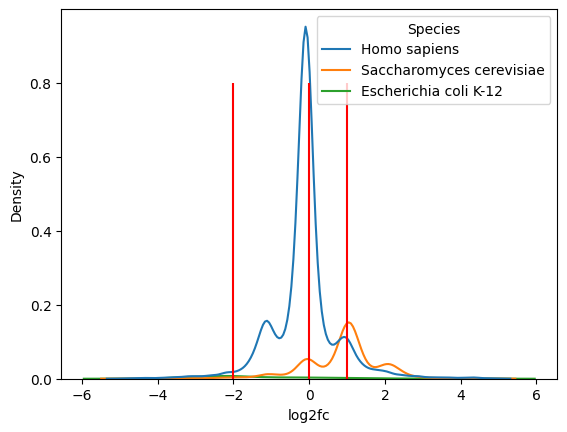

In [131]:
import seaborn as sns

sns.kdeplot(
    data=restable.loc[(restable["log2fc"] > -5) & (restable["log2fc"] < 5)],
    x="log2fc",
    hue_order=["Homo sapiens", "Saccharomyces cerevisiae", "Escherichia coli K-12"],
    # x="mean_intensity",
    hue="Species",
    fill=False,
    # log_scale=(10, False),
)
plt.vlines(x=[-2, 0, 1], ymin=0, ymax=0.8, color="r")

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


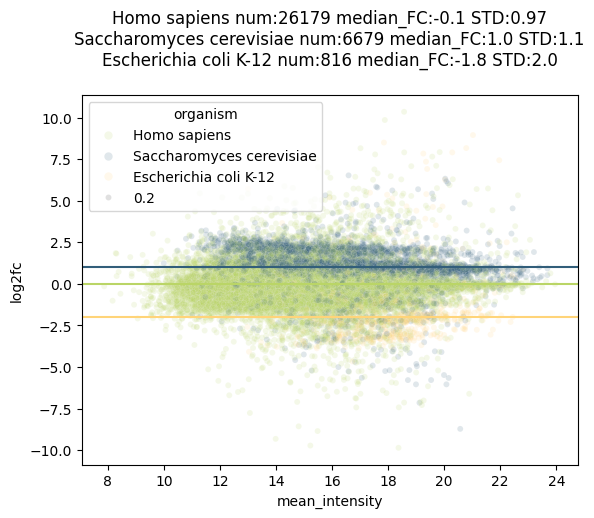

In [132]:
import directlfq.benchmarking as lfqbenchmark

fig, axes = plt.subplots(1, 1)
fcplotter_directLFQ = lfqbenchmark.MultiOrganismIntensityFCPlotter(
    ax=axes,
    resultstable_w_ratios=restable_directlfq,
    organisms_to_plot=[
        "Homo sapiens",
        "Saccharomyces cerevisiae",
        "Escherichia coli K-12",
    ],
    # organisms_to_plot=["Homo sapien", "Yeast", "Ecoli"],
    fcs_to_expect=[0, 1, -2],
    # title=cfg.FC.TITLE,
)

In [76]:
restable.loc[restable["Species"] == "Homo sapiens", "deviation"] = abs(
    restable.loc[restable["Species"] == "Homo sapiens", "log2fc"] - 0
)
restable.loc[restable["Species"] == "Saccharomyces cerevisiae", "deviation"] = abs(
    restable.loc[restable["Species"] == "Saccharomyces cerevisiae", "log2fc"] - 1
)
restable.loc[restable["Species"] == "Escherichia coli K-12", "deviation"] = abs(
    restable.loc[restable["Species"] == "Escherichia coli K-12", "log2fc"] + 2
)

In [99]:
# Calculate the threshold for the 80th percentile of the deviation
deviation_threshold = restable["deviation"].quantile(0.5)
restable_directlfq_filtered = restable_directlfq
# Filter out the entries with deviation greater than the threshold
restable_directlfq_filtered.formated_dataframe = restable[
    restable["deviation"] <= deviation_threshold
]
restable_filtered = restable_directlfq_filtered.formated_dataframe

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='log2fc', ylabel='Density'>

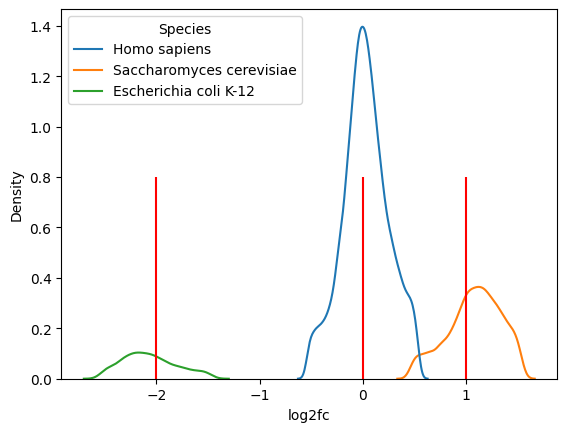

In [100]:
import seaborn as sns

sns.kdeplot(
    data=restable_filtered.loc[
        (restable_filtered["log2fc"] > -5) & (restable_filtered["log2fc"] < 5)
    ],
    x="log2fc",
    hue_order=["Homo sapiens", "Saccharomyces cerevisiae", "Escherichia coli K-12"],
    # x="mean_intensity",
    hue="Species",
    fill=False,
    # log_scale=(10, False),
)
plt.vlines(x=[-2, 0, 1], ymin=0, ymax=0.8, color="r")

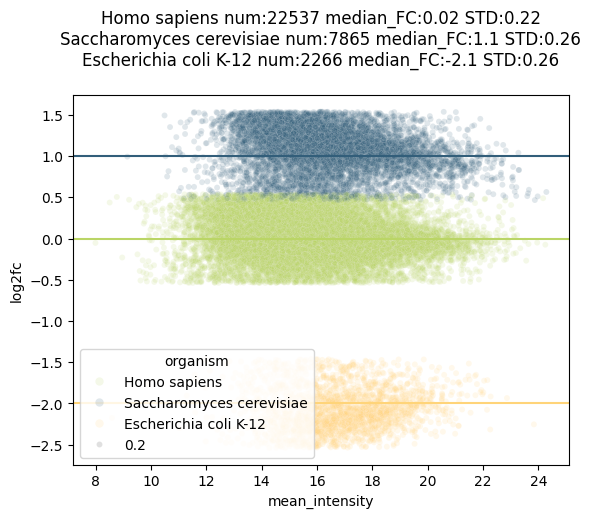

In [101]:
import directlfq.benchmarking as lfqbenchmark

fig, axes = plt.subplots(1, 1)
fcplotter_directLFQ = lfqbenchmark.MultiOrganismIntensityFCPlotter(
    ax=axes,
    resultstable_w_ratios=restable_directlfq_filtered,
    organisms_to_plot=[
        "Homo sapiens",
        "Saccharomyces cerevisiae",
        "Escherichia coli K-12",
    ],
    # organisms_to_plot=["Homo sapien", "Yeast", "Ecoli"],
    fcs_to_expect=[0, 1, -2],
    # title=cfg.FC.TITLE,
)

In [58]:
# statistics
pd.set_option("mode.use_inf_as_na", True)
restable.loc[restable["Species"] == "Homo sapiens"]["log2fc"].median(skipna=True)
restable.loc[restable["Species"] == "Saccharomyces cerevisiae"]["log2fc"].median(
    skipna=True
)
restable.loc[restable["Species"] == "Escherichia coli K-12"]["log2fc"].median(
    skipna=True
)

/tmp/ipykernel_538562/4022025806.py:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option("mode.use_inf_as_na", True)


0.03606562526658941

1.0531555960768904

-0.7398933185281411

In [59]:
restable.loc[restable["Species"] == "Homo sapiens"]["log2fc"].std(skipna=True)
restable.loc[restable["Species"] == "Saccharomyces cerevisiae"]["log2fc"].std(
    skipna=True
)
restable.loc[restable["Species"] == "Escherichia coli K-12"]["log2fc"].std(skipna=True)

1.4068277154499345

1.6057385749742523

2.1572215029478663

## TODO for picked group FDR
columns need to be updated see here: https://github.com/kusterlab/picked_group_fdr/blob/90597185c641d8006d950c1b7b1ff56ad5552022/picked_group_fdr/parsers/maxquant.py#L20

specifically: calculate PEP and write it into evidence

In [10]:
evidence_folder = "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/test/evidence_swaps"
out_path1, evidence = prepare_evidence_for_pickedgroupfdr(
    swaps_result_dir="/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/B_5140_20240912_134730_820676/",
    run_name="B_5140",
    out_dir=evidence_folder,
)

In [37]:
evidence_path = (
    "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/test/evidence_swaps/evidence_B_5140.txt"
)
out_dir = "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/test/orignal.proteinGroups.txt"
fasta_y_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/detectebility/uniprot-proteome_Ecoli_UP000000625_reviewed_20220523.fasta"
fasta_e_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/detectebility/uniprot_Scerevisiae_20220714_canonical.fasta"
fasta_h_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/detectebility/uniprot-proteome_human_reviewed_canonical_20220419.fasta"

In [11]:
import picked_group_fdr.pipeline as picked_group_fdr
from picked_group_fdr.digestion_params import DigestionParams

2024-09-22 10:32:51,623 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-22 10:32:51,782 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='Length', ylabel='Score'>

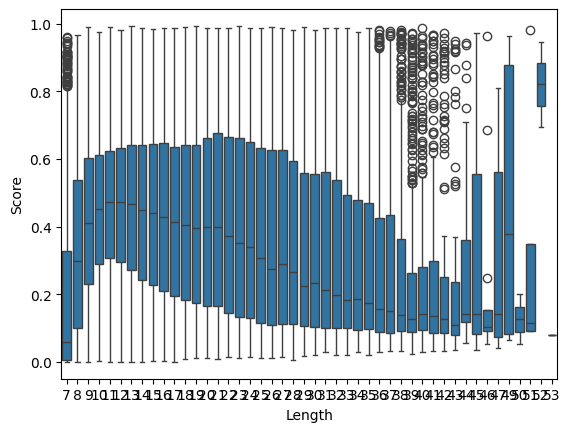

In [28]:
import seaborn as sns

sns.boxplot(data=evidence, x="Length", y="Score")

In [ ]:
digest_param_list = [DigestionParams("trypsinp", "full", 7, 60, 2, "KR", False)]
picked_group_fdr.run_picked_group_fdr(
    evidence_files=[evidence_path],
    protein_groups_out=out_dir,
    fasta_files=[fasta_e_path, fasta_h_path, fasta_y_path],
    do_quant=True,
    lfq_min_peptide_ratios=1,
    digest_params_list=digest_param_list,
    suppress_missing_peptide_warning=False,
)

Problem: psm level FDR control too rigid, only 13 protein groups left

In [5]:
import pandas as pd

protein_groups = pd.read_csv(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/test/proteinGroups.txt", sep="\t"
)

# Run DirectLFQ

## 30min HYE search evidence

In [170]:
tmp_evidence = pd.read_csv(
    "/cmnfs/data/proteomics/timstof_HYE_mixture/PXD028735/combined/txt/evidence.txt",
    sep="\t",
)

/tmp/ipykernel_538562/2441800060.py:1: DtypeWarning: Columns (4,5,62,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_evidence = pd.read_csv(


In [172]:
tmp_evidence["Raw file"].value_counts()

Raw file
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_01    55777
LFQ_timsTOFPro_PASEF_Condition_A_Sample_Gamma_01    55491
LFQ_timsTOFPro_PASEF_Condition_A_Sample_Gamma_02    55341
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Gamma_01    55266
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_02    55191
LFQ_timsTOFPro_PASEF_Condition_A_Sample_Beta_02     54630
LFQ_timsTOFPro_PASEF_Condition_A_Sample_Beta_01     54446
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_03    54364
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Gamma_02    54139
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Beta_02     53937
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Beta_03     52968
Name: count, dtype: int64

In [171]:
tmp_evidence_unique_ion = tmp_evidence.drop_duplicates(
    subset=["Modified sequence", "Charge"]
)

In [165]:
evidence_30min_HYE = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/species_mix/DDA/txt_HYE_5ug/evidence.txt", sep="\t"
)

/tmp/ipykernel_538562/2374514078.py:1: DtypeWarning: Columns (60,68) have mixed types. Specify dtype option on import or set low_memory=False.
  evidence_30min_HYE = pd.read_csv(


In [166]:
evidence_30min_HYE["Raw file"].value_counts()

Raw file
MixB_5ug_30min_7R_R2_RA1_1_5136    48415
MixB_5ug_30min_7R_R3_RA1_1_5138    48351
MixB_5ug_30min_7R_R1_RA1_1_5134    48287
MixB_5ug_30min_7R_R4_RA1_1_5140    48036
MixA_5ug_30min_7R_R3_RA1_1_5137    47480
MixA_5ug_30min_7R_R2_RA1_1_5135    47452
MixA_5ug_30min_7R_R1_RA1_1_5133    47383
MixA_5ug_30min_7R_R4_RA1_1_5139    47158
Name: count, dtype: int64

In [169]:
evidence_30min_HYE["Type"].value_counts()

Type
TIMS-MULTI-MSMS    382562
Name: count, dtype: int64

In [167]:
evidence_30min_HYE_unique_ion = evidence_30min_HYE.drop_duplicates(
    subset=["Modified sequence", "Charge"]
)

In [168]:
evidence_30min_HYE_unique_modseq = evidence_30min_HYE.drop_duplicates(
    subset=["Modified sequence"]
)

## 120min seperate exp merged search evidence

In [ ]:
evidence_120min_sep = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/species_mix/DDA/txt_HYE_120min_sep/evidence.txt", sep="\t"
)

In [ ]:
evidence_120min_sep.value_counts(subset=["Taxonomy names", "Raw file"])

Taxonomy names                                               Raw file                               
Homo sapiens                                                 Hela_120min_15ug_R1_RA1_1_5220             62355
Saccharomyces cerevisiae                                     20240902_Yeast_15ug_120min_R1_1_1_5879     35651
Escherichia coli K-12                                        20240902_Ecolit_15ug_120min_R1_1_1_5881    19284
Saccharomyces cerevisiae;Homo sapiens                        Hela_120min_15ug_R1_RA1_1_5220               916
Saccharomyces cerevisiae                                     Hela_120min_15ug_R1_RA1_1_5220               893
Saccharomyces cerevisiae;Homo sapiens                        20240902_Yeast_15ug_120min_R1_1_1_5879       418
Homo sapiens                                                 20240902_Yeast_15ug_120min_R1_1_1_5879       290
Saccharomyces cerevisiae                                     20240902_Ecolit_15ug_120min_R1_1_1_5881      236
Homo sapiens       

In [ ]:
filtered_evidence = evidence_120min_sep[
    (evidence_120min_sep["Taxonomy names"] == "Homo sapiens")
    & (evidence_120min_sep["Raw file"] == "Hela_120min_15ug_R1_RA1_1_5220")
    | (evidence_120min_sep["Taxonomy names"] == "Saccharomyces cerevisiae")
    & (evidence_120min_sep["Raw file"] == "20240902_Yeast_15ug_120min_R1_1_1_5879")
    | (evidence_120min_sep["Taxonomy names"] == "Escherichia coli K-12")
    & (evidence_120min_sep["Raw file"] == "20240902_Ecolit_15ug_120min_R1_1_1_5881")
]
filtered_evidence["ion"] = (
    filtered_evidence["Modified sequence"]
    + "_"
    + filtered_evidence["Charge"].astype(str)
)

/tmp/ipykernel_538562/790493666.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_evidence["ion"] = (


In [164]:
filtered_evidence_unique_ion = filtered_evidence.drop_duplicates(
    subset=["Modified sequence", "Charge"]
)

In [ ]:
evidence_120min_sep_unique_ion = evidence_120min_sep.drop_duplicates(
    subset=["Modified sequence", "Charge"]
)

## Filter input

In [118]:
input_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/test/generic_input.aq_reformat.tsv"

In [119]:
generic_input = pd.read_csv(input_path, sep="\t")

In [120]:
generic_input_filtered = generic_input.loc[
    generic_input["ion"].isin(filtered_evidence["ion"])
]

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc2d0e5b7c0>


In [121]:
generic_input_filtered.to_csv(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/test/generic_input_filtered.aq_reformat.tsv",
    sep="\t",
    index=False,
)

## directLFQ

In [134]:
from postprocessing.protein_quant import prepare_generic_input_from_result_dir_list

result_dir = "/cmnfs/proj/ORIGINS/SWAPS_exp/mixture/120min_library_im_ref"
generic_input_path = prepare_generic_input_from_result_dir_list(
    matching_files, result_dir=result_dir
)

2024-10-01 14:46:50,036 - postprocessing.protein_quant - INFO - Processing B_5134
2024-10-01 14:46:52,428 - postprocessing.protein_quant - INFO - Processing A_5133
2024-10-01 14:46:55,394 - postprocessing.protein_quant - INFO - Processing A_5137
2024-10-01 14:46:58,363 - postprocessing.protein_quant - INFO - Processing B_5138
2024-10-01 14:47:01,400 - postprocessing.protein_quant - INFO - Processing B_5140
2024-10-01 14:47:04,499 - postprocessing.protein_quant - INFO - Processing A_5139
2024-10-01 14:47:07,078 - postprocessing.protein_quant - INFO - Processing A_5135
2024-10-01 14:47:10,178 - postprocessing.protein_quant - INFO - Processing B_5136
2024-10-01 14:47:14,633 - postprocessing.protein_quant - INFO - Score thresholds by species: Homo sapiens_0.2_Saccharomyces cerevisiae_0.9_Escherichia coli K-12_0.2


In [135]:
import directlfq.lfq_manager as lfq_manager

input_path = generic_input_path
input_file = lfq_manager.prepare_input_filename(input_path)
lfq_manager.run_lfq(input_file=input_file, input_type_to_use="aq_reformat")

2024-10-01 14:47:19,133 - directlfq.lfq_manager - INFO - Starting directLFQ analysis.
2024-10-01 14:47:19,530 - directlfq.lfq_manager - INFO - Performing sample normalization.
2024-10-01 14:47:19,567 - directlfq.lfq_manager - INFO - Estimating lfq intensities.
2024-10-01 14:47:19,578 - directlfq.protein_intensity_estimation - INFO - 12754 lfq-groups total
2024-10-01 14:47:29,661 - directlfq.protein_intensity_estimation - INFO - using 32 processes
2024-10-01 14:47:29,809 - directlfq.protein_intensity_estimation - INFO - lfq-object 0
2024-10-01 14:47:29,901 - directlfq.protein_intensity_estimation - INFO - lfq-object 100
2024-10-01 14:47:29,983 - directlfq.protein_intensity_estimation - INFO - lfq-object 200
2024-10-01 14:47:30,079 - directlfq.protein_intensity_estimation - INFO - lfq-object 300
2024-10-01 14:47:30,154 - directlfq.protein_intensity_estimation - INFO - lfq-object 400
2024-10-01 14:47:30,232 - directlfq.protein_intensity_estimation - INFO - lfq-object 500
2024-10-01 14:47:

## Protein Grouping

In [50]:
protein_group = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/species_mix/library/txt_HYE_120min_sep/proteinGroups.txt",
    sep="\t",
)
protein_group["Species"] = protein_group["Taxonomy names"]
protein_group_updated_path = os.path.join(
    result_dir, "proteinGroups_120min_sep_merged_search_species.txt"
)
protein_group.to_csv(
    protein_group_updated_path,
    sep="\t",
    index=False,
)

In [58]:
# prepare sample map
samplemap = pd.DataFrame(
    [
        ["A_5137", "A"],
        ["A_5139", "A"],
        ["B_5138", "B"],
        ["B_5140", "B"],
        ["A_5135", "A"],
        ["B_5136", "B"],
        ["A_5133", "A"],
        ["B_5134", "B"],
    ],
    columns=["sample", "condition"],
)
sample_path = os.path.join(result_dir, "samplemap.tsv")
samplemap.to_csv(
    os.path.join(sample_path),
    sep="\t",
    index=False,
)

## Plot FoldChange

In [136]:
from typing import Literal


def reformat_picked_group_fdr_output(
    protein_groups_path: str, int_col: Literal["LFQ Intensity ", "Intensity ", "iBAQ "]
):
    protein_groups = pd.read_csv(protein_groups_path, sep="\t")
    # Rename columns with "LFQ Intensity [placeholder]" to just "placeholder"
    protein_groups.columns = [
        col.replace(int_col, "") if int_col in col else col
        for col in protein_groups.columns
    ]
    protein_groups["protein"] = protein_groups["Protein IDs"]
    protein_groups.to_csv(
        protein_groups_path[:-4] + f"_{int_col[:-1]}.txt", sep="\t", index=False
    )

In [137]:
reformat_picked_group_fdr_output(
    protein_groups_path=os.path.join(result_dir, "proteinGroups.txt"),
    int_col="LFQ Intensity ",
)

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/directlfq/benchmarking.py:153: RuntimeWarning: divide by zero encountered in log2
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/directlfq/benchmarking.py:153: RuntimeWarning: invalid value encountered in scalar subtract
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]


(9792, 14)

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


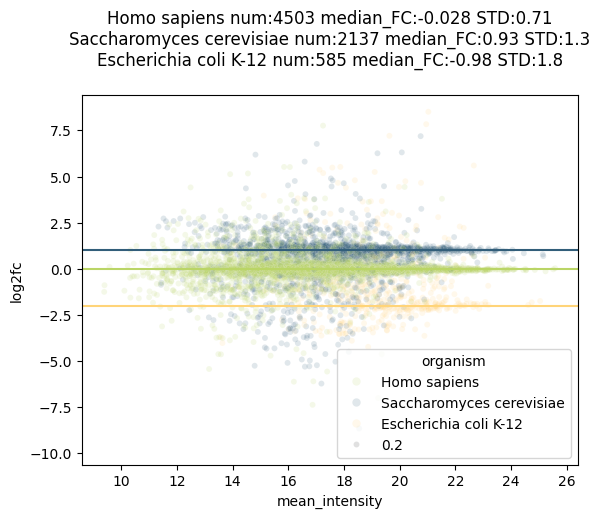

In [138]:
import directlfq.utils as lfqutils
import directlfq.benchmarking as lfqbenchmark

organism_annotator = lfqbenchmark.OrganismAnnotatorMaxQuant(
    mapping_file=protein_group_updated_path,
    protein_column="Protein IDs",
)
samplemap_df_directlfq = lfqutils.load_samplemap(sample_path)
samples_used_directlfq = lfqutils.get_samples_used_from_samplemap_df(
    samplemap_df_directlfq, cond1="A", cond2="B"
)

restable_directlfq = lfqbenchmark.ResultsTableDirectLFQ(
    input_file=generic_input_path + ".aq_reformat.protein_intensities.tsv",
    # input_file=os.path.join(result_dir, "proteinGroups_iBAQ.txt"),
    input_name="directLFQ",
    samples_c1=samples_used_directlfq[0],
    samples_c2=samples_used_directlfq[1],
)
organism_annotator.annotate_table_with_organism(restable_directlfq)
restable_directlfq.formated_dataframe.shape
fig, axes = plt.subplots(1, 1)
fcplotter_directLFQ = lfqbenchmark.MultiOrganismIntensityFCPlotter(
    ax=axes,
    resultstable_w_ratios=restable_directlfq,
    organisms_to_plot=[
        "Homo sapiens",
        "Saccharomyces cerevisiae",
        "Escherichia coli K-12",
    ],
    # organisms_to_plot=["Homo sapien", "Yeast", "Ecoli"],
    fcs_to_expect=[0, 1, -2],
    # title=cfg.FC.TITLE,
)
fig.savefig(
    os.path.join(
        result_dir,
        f"FC_plot_protein_score_MT_{score_thres}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='log2fc', ylabel='Density'>

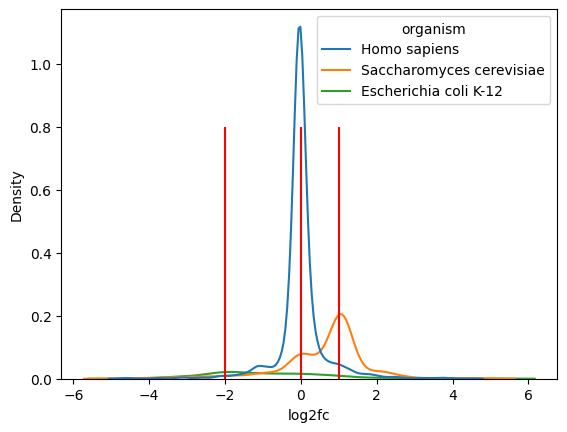

In [140]:
import seaborn as sns

sns.kdeplot(
    data=restable_directlfq.formated_dataframe.loc[
        (restable_directlfq.formated_dataframe["log2fc"] > -5)
        & (restable_directlfq.formated_dataframe["log2fc"] < 5)
    ],
    x="log2fc",
    # x="mean_intensity",
    hue="organism",
    fill=False,
    # log_scale=(10, False),
)
plt.vlines(x=[-2, 0, 1], ymin=0, ymax=0.8, color="r")

## Troubleshooting

In [200]:
from collections import Counter


def get_protein_list_from_list(proteins_list):
    protein_list = [item for sublist in proteins_list for item in sublist]
    element_counts = Counter(protein_list)
    df_counts = pd.DataFrame(
        list(element_counts.items()), columns=[input_to_join, "Count"]
    )
    logging.info("Mean of protein count: %s", df_counts["Count"].mean())
    return protein_list

In [230]:
restable = restable_directlfq.formated_dataframe

In [203]:
mq_evidence_120min_HYE = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/species_mix/DDA/mq_combined_120min_HYE.txt", sep="\t"
)

/tmp/ipykernel_510517/2486365593.py:1: DtypeWarning: Columns (16,61) have mixed types. Specify dtype option on import or set low_memory=False.
  mq_evidence_120min_HYE = pd.read_csv(


In [209]:
example_maxquant_result_ref["Raw file"].unique()

array(['decoy', '20240902_Yeast_15ug_120min_R1_1_1_5879',
       'MixA_5ug_30min_7R_R4_RA1_1_5139',
       '20240902_Ecolit_15ug_120min_R1_1_1_5881',
       'Hela_120min_15ug_R1_RA1_1_5220'], dtype=object)

In [208]:
example_maxquant_result_ref[["Raw file", "Taxonomy names"]].value_counts()

Raw file                                 Taxonomy names          
Hela_120min_15ug_R1_RA1_1_5220           Homo sapiens                47778
decoy                                    Homo sapiens                47587
20240902_Yeast_15ug_120min_R1_1_1_5879   Saccharomyces cerevisiae    22333
decoy                                    Saccharomyces cerevisiae    22160
20240902_Ecolit_15ug_120min_R1_1_1_5881  Escherichia coli K-12       16423
decoy                                    Escherichia coli K-12       16122
20240902_Yeast_15ug_120min_R1_1_1_5879   Homo sapiens                    2
20240902_Ecolit_15ug_120min_R1_1_1_5881  Homo sapiens                    1
Name: count, dtype: int64

In [232]:
mix_30_ecoli_proteins = get_protein_list_from_list(
    mix_grouping_30min.loc[
        (mix_grouping_30min["Taxonomy names"] == "Escherichia coli K-12")
    ]["Protein IDs"].str.split(";")
)

2024-09-20 12:39:36,961 - root - INFO - Mean of protein count: 1.0


In [243]:
high_fc_ecoli = restable.loc[
    (restable["organism"] == "Escherichia coli K-12") & (restable["log2fc"] > -1)
][input_to_join]
high_fc_ecoli_protein = get_protein_list_from_list(high_fc_ecoli.str.split(";"))

2024-09-20 12:43:31,463 - root - INFO - Mean of protein count: 1.0


In [244]:
low_fc_ecoli = restable.loc[
    (restable["organism"] == "Escherichia coli K-12") & (restable["log2fc"] < -1)
][input_to_join]
low_fc_ecoli_protein = get_protein_list_from_list(low_fc_ecoli.str.split(";"))

2024-09-20 12:43:32,550 - root - INFO - Mean of protein count: 1.0045385779122542


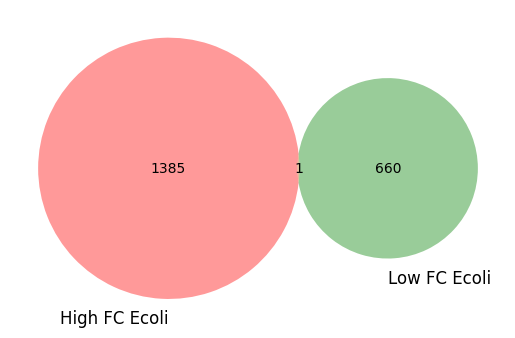

In [245]:
# from matplotlib_venn import venn2
from matplotlib_venn import venn3

venn2(
    [set(high_fc_ecoli_protein), set(low_fc_ecoli_protein)],
    set_labels=("High FC Ecoli", "Low FC Ecoli"),
)

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


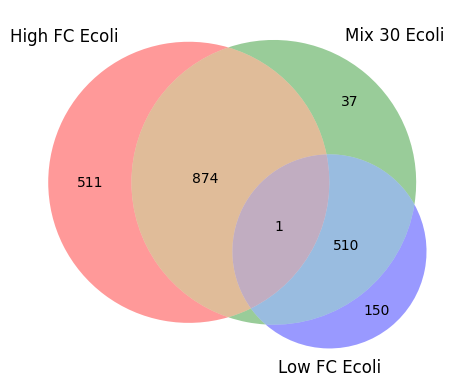

In [246]:
venn3(
    [set(high_fc_ecoli_protein), set(mix_30_ecoli_proteins), set(low_fc_ecoli_protein)],
    set_labels=("High FC Ecoli", "Mix 30 Ecoli", "Low FC Ecoli"),
)